# Imports

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

# custom functions
from evaluation_functions import time_based_evaluation, evaluate_model_with_train
from pipeline_transformers import LogTransformer, FeatureCreation, FeatureRemoval

shap.initjs()

C:\Users\nbeha\AppData\Local\Temp\ipykernel_2268\4203152875.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\nbeha\anaconda3\envs\credit-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data ingestion

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
valid = pd.read_csv('valid.csv')
all_data = pd.concat([train, test, valid])

# treatments applied to the training data (check EDA notebook for details)
train = train[train['general_a_vencer_weighted_periodo_div_pct_risco'] >= 0]

train['random'] = np.random.rand(train.shape[0])
test['random'] = np.random.rand(test.shape[0])
valid['random'] = np.random.rand(valid.shape[0])
all_data['random'] = np.random.rand(all_data.shape[0])

keys = ['fake_cnpj', 'date_reference']
target = 'TARGET_default_within_11m'

features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum', # necessary to engineered features
    'general_lost_sum', # necessary to engineered features
    'general_vencido_sum', # necessary to engineered features
    'risco_total',
    'random'
    ]

log_transform_features = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'general_limite_de_cred_sum',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_lost_sum',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum',
    'general_vencido_sum_sum_pct_risco']

# commented: features that may induce bias/information from other risk models


# Model pipeline

## Baseline model

In [3]:
baseline_model = Pipeline([
    ('model', LGBMClassifier(random_state=999, max_depth=5, verbose=-1))
])

all_columns = [c for c in train.columns if c not in keys + [target]]

baseline_model.fit(train[all_columns], train[target])
preds = baseline_model.predict_proba(test[all_columns])[:, 1]
train_preds = baseline_model.predict_proba(train[all_columns])[:, 1]

In [4]:
# Train
print('AUC:', roc_auc_score(train[target], train_preds))
print('Precision:', precision_score(train[target], train_preds > 0.5))
print('Recall:', recall_score(train[target], train_preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(train[target], train_preds > 0.5))
print(confusion_matrix(train[target], train_preds > 0.5, normalize='true'))

AUC: 0.9512438200550098
Precision: 0.8759200841219769
Recall: 0.4867075664621677
Confusion Matrix:
[[22539   236]
 [ 1757  1666]]
[[0.98963776 0.01036224]
 [0.51329243 0.48670757]]


In [5]:
# Test
print('AUC:', roc_auc_score(test[target], preds))
print('Precision:', precision_score(test[target], preds > 0.5))
print('Recall:', recall_score(test[target], preds > 0.5))
print('Confusion Matrix:')
print(confusion_matrix(test[target], preds > 0.5))
print(confusion_matrix(test[target], preds > 0.5, normalize='true'))

AUC: 0.8324668313376375
Precision: 0.570446735395189
Recall: 0.18072945019052802
Confusion Matrix:
[[15733   250]
 [ 1505   332]]
[[0.98435838 0.01564162]
 [0.81927055 0.18072945]]


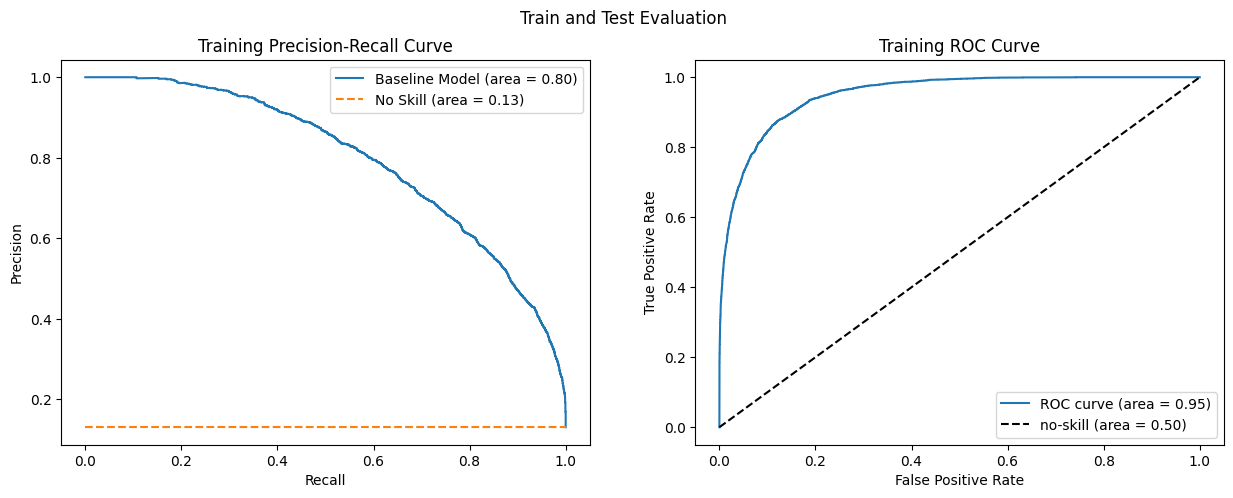

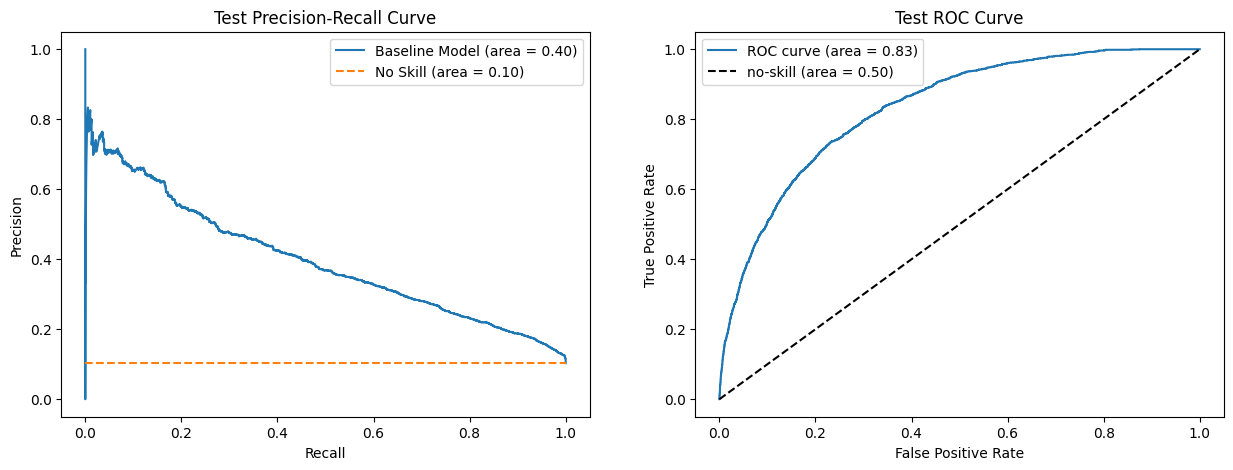

In [6]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

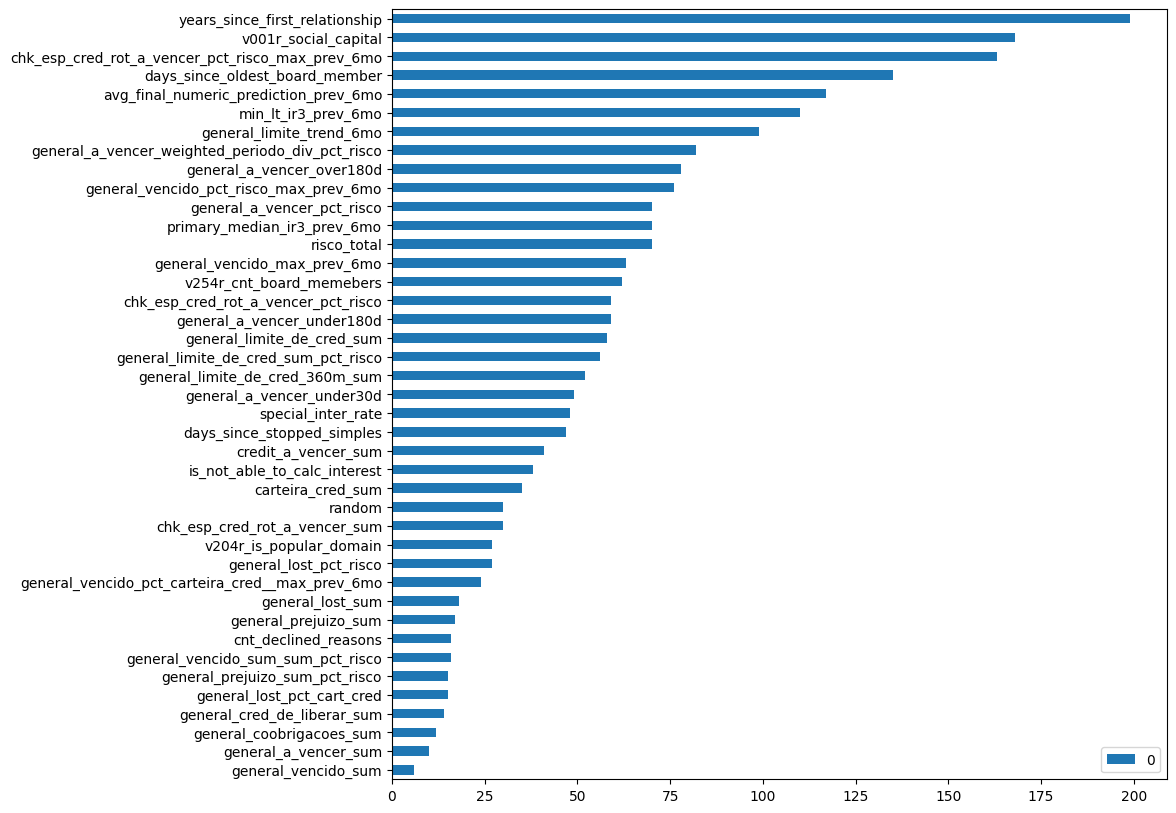

In [7]:
pd.DataFrame(baseline_model[0].feature_importances_, index=all_columns).sort_values(0).plot(kind='barh', figsize=(10, 10))
plt.show()

## Model with reduced feature set

In [8]:
model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('lgbm', LGBMClassifier(max_depth=5, random_state=123, verbose=-1))
])

model.fit(train[features], train[target])
preds = model.predict_proba(test[features])[:, 1]
train_preds = model.predict_proba(train[features])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

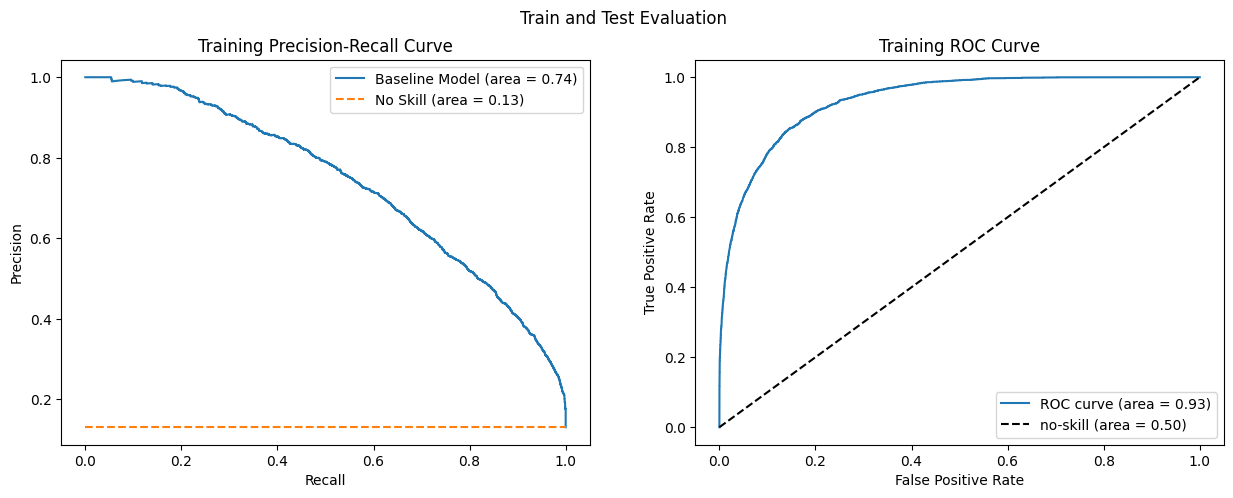

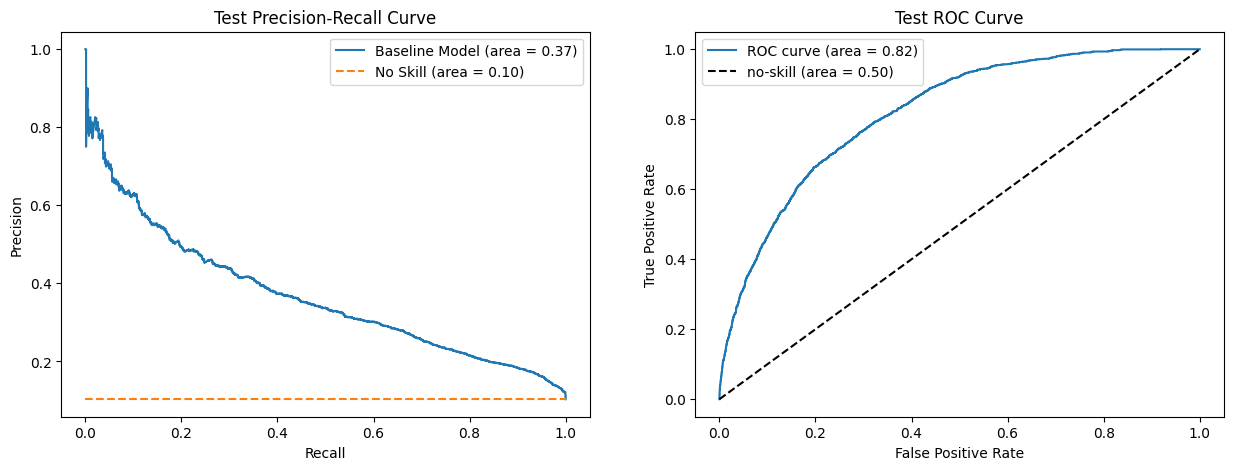

In [9]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

In [10]:
baseline_importances = pd.DataFrame(baseline_model[0].feature_importances_, index=all_columns, columns=['importance']).sort_values('importance', ascending=False)
new_importances = pd.DataFrame(model[3].feature_importances_, index=features, columns=['importance']).sort_values('importance', ascending=False)

In [11]:
baseline_importances.join(new_importances, how='outer', lsuffix='_baseline', rsuffix='_new').fillna(0).sort_values('importance_baseline', ascending=False)

,importance_baseline,importance_new
years_since_first_relationship,199,308.0
v001r_social_capital,168,0.0
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,163,221.0
days_since_oldest_board_member,135,217.0
avg_final_numeric_prediction_prev_6mo,117,0.0
min_lt_ir3_prev_6mo,110,0.0
general_limite_trend_6mo,99,158.0
general_a_vencer_weighted_periodo_div_pct_risco,82,179.0
general_a_vencer_over180d,78,0.0
general_vencido_pct_risco_max_prev_6mo,76,92.0


In [12]:
# Altough some relevant features for the training dataset were removed in our EDA filter,
# the model still performs well in the test dataset

# Hyperparameter optimization

In [13]:
# def objective(trial):
#     param = {
#         'max_depth': trial.suggest_int('max_depth', 2, 5),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 300),
#         'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
#         'subsample': trial.suggest_float('subsample', 0.1, 0.6),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#     }
#     model = Pipeline([
#         ('log_transform', LogTransformer(log_transform_features)),
#         ('create_features', FeatureCreation()),
#         ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
#         ('lgbm', LGBMClassifier(**param, verbose=-1, random_state=123))
#     ], verbose=False)
#     model.fit(train[features], train[target])
#     preds = model.predict_proba(test[features])[:, 1]
#     return roc_auc_score(test[target], preds)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# study.best_params

In [14]:
# best_params = study.best_params

best_params = {
 'max_depth': 5,
 'learning_rate': 0.04112868060463783,
 'n_estimators': 82,
 'min_child_samples': 66,
 'subsample': 0.2591667458499961,
 'colsample_bytree': 0.3607625455725305,
 'reg_alpha': 0.05864006204720501,
 'reg_lambda': 0.19828296427132538}

In [15]:
optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', CalibratedClassifierCV(LGBMClassifier(**best_params, random_state=1), method='isotonic', cv=5)),
])

fitted_model = optimal_model.fit(train[features], train[target])
preds = fitted_model.predict_proba(test[features])[:, 1]
train_preds = fitted_model.predict_proba(train[features])[:, 1]

uncalibrated_optimal_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', LGBMClassifier(**best_params, random_state=1)),
])

uncalibrated_optimal_model.fit(train[features], train[target])
preds_wo_cal = uncalibrated_optimal_model.predict_proba(test[features])[:, 1]
train_preds_wo_cal = uncalibrated_optimal_model.predict_proba(train[features])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2738, number of negative: 18220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4865
[LightGBM] [Info] Number of data points in the train set: 20958, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130642 -> initscore=-1.895292
[LightGBM] [Info] Start training from score -1.895292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


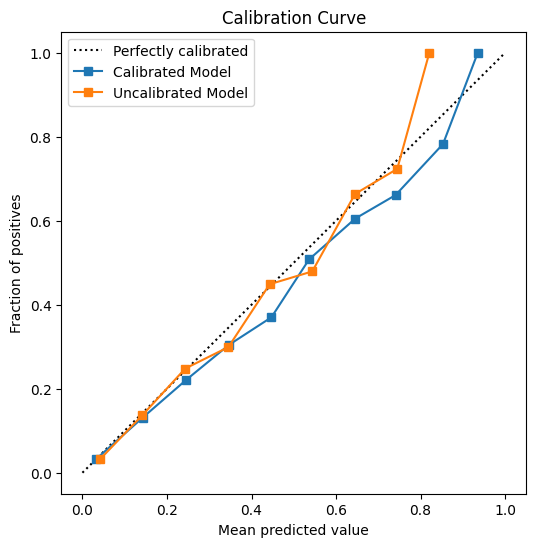

In [16]:
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
fraction_of_positives_wo_cal, mean_predicted_value_wo_cal = calibration_curve(test[target], preds_wo_cal, n_bins=10)
fraction_of_positives, mean_predicted_value = calibration_curve(test[target], preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrated Model")
plt.plot(mean_predicted_value_wo_cal, fraction_of_positives_wo_cal, "s-", label="Uncalibrated Model")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title('Calibration Curve')
plt.legend()
plt.show()

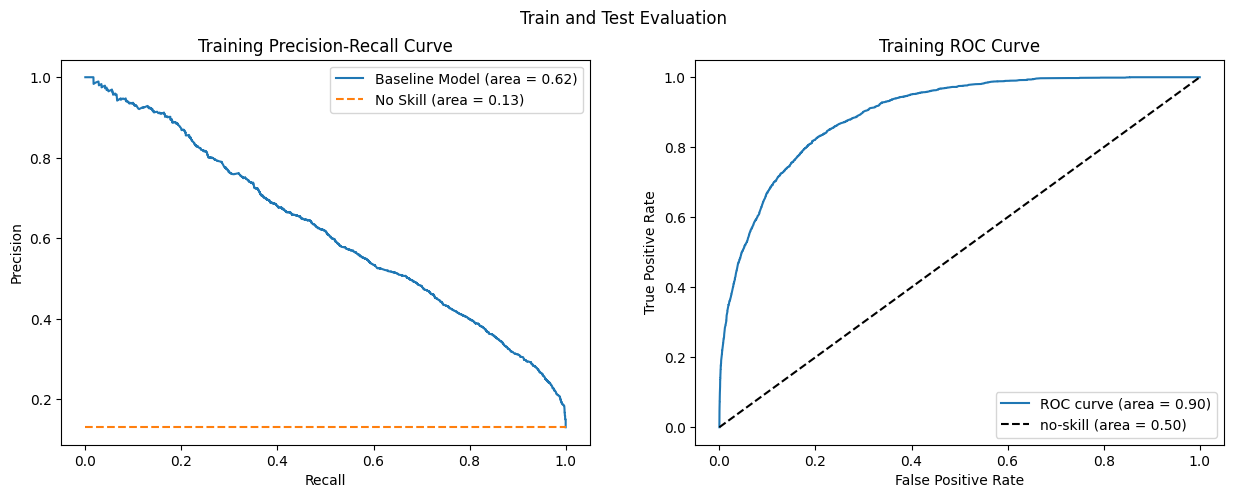

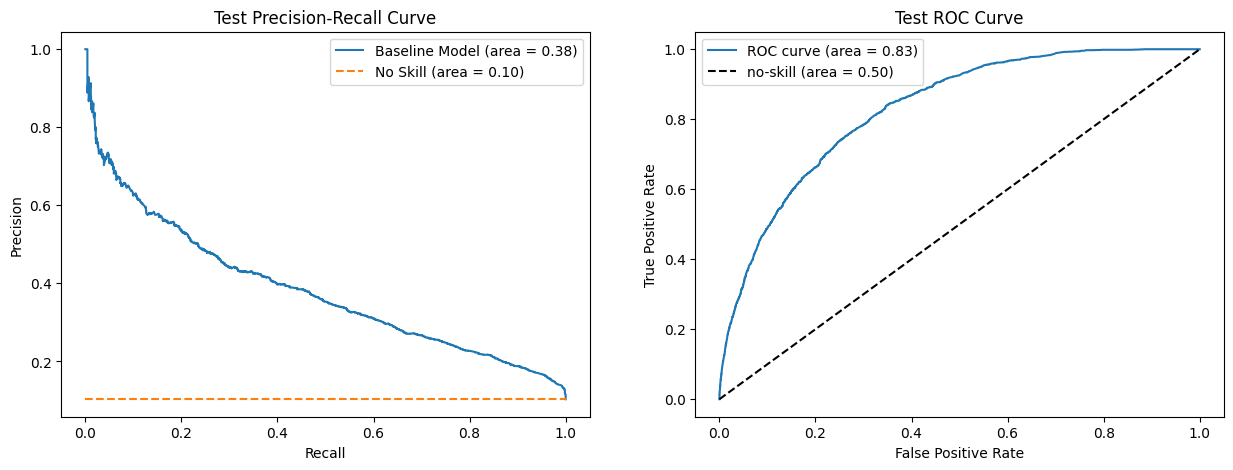

In [17]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

### Linear Model Alternative


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

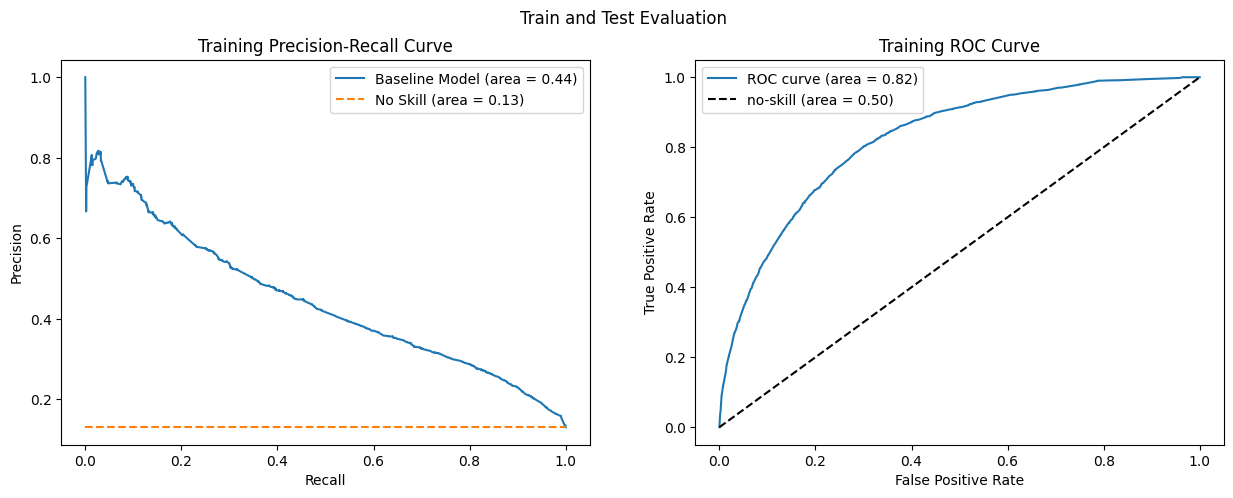

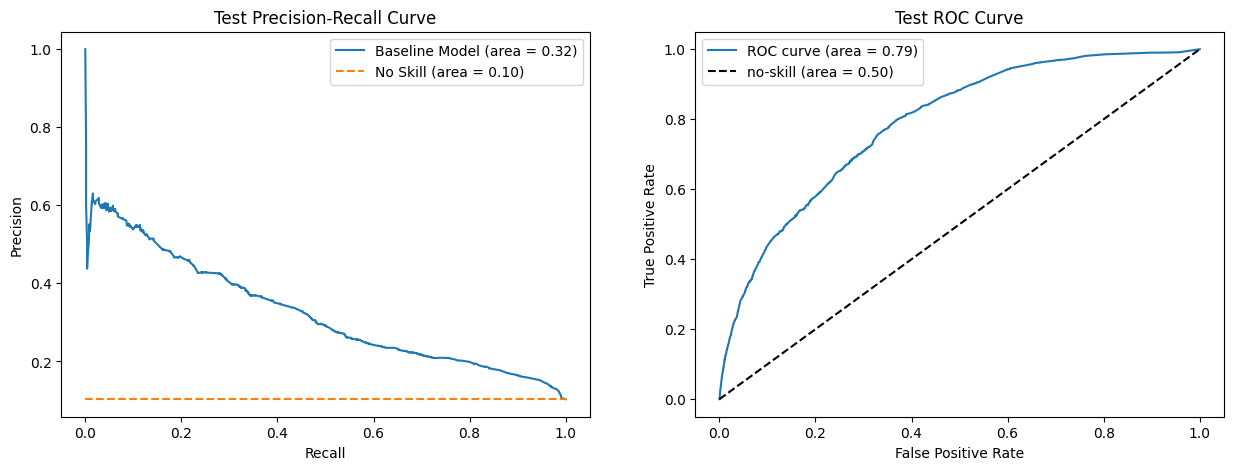

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
import numpy as np

class infinite_to_zero(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.replace([np.inf, -np.inf], 0)


linear_model = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('infinite_to_zero', infinite_to_zero()), # replace infinite values with 0,
     # this case means that the customer doesnt have one of the engineered  components
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('classifier', CalibratedClassifierCV(LogisticRegression(), method='isotonic', cv=5)),
])

fitted_lr = linear_model.fit(train[features], train[target])
preds = fitted_lr.predict_proba(test[features])[:, 1]
train_preds = fitted_lr.predict_proba(train[features])[:, 1]

evaluate_model_with_train(train[target], test[target], train_preds, preds)

In [19]:
coef_df = pd.DataFrame(fitted_lr[-1].calibrated_classifiers_[0].estimator.coef_, columns=features).T
coef_df.columns = ['value']
intercept_df = pd.DataFrame(fitted_lr[-1].calibrated_classifiers_[0].estimator.intercept_, index=['intercept'], columns=['value'])
coef_df['abs_value'] = coef_df['value'].abs()
pd.concat([intercept_df, coef_df], axis=0).sort_values('abs_value', ascending=False).drop('abs_value', axis=1)

,value
general_lost_sum,-2.940523
v254r_cnt_board_memebers,-0.842440
general_a_vencer_pct_risco,0.508002
years_since_first_relationship,-0.377214
cnt_declined_reasons,0.218800
chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,0.208718
general_vencido_max_prev_6mo,0.196816
v204r_is_popular_domain,0.193345
general_lost_pct_risco,0.172819
general_a_vencer_weighted_periodo_div_pct_risco,0.148003


# Time-based Evaluation


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


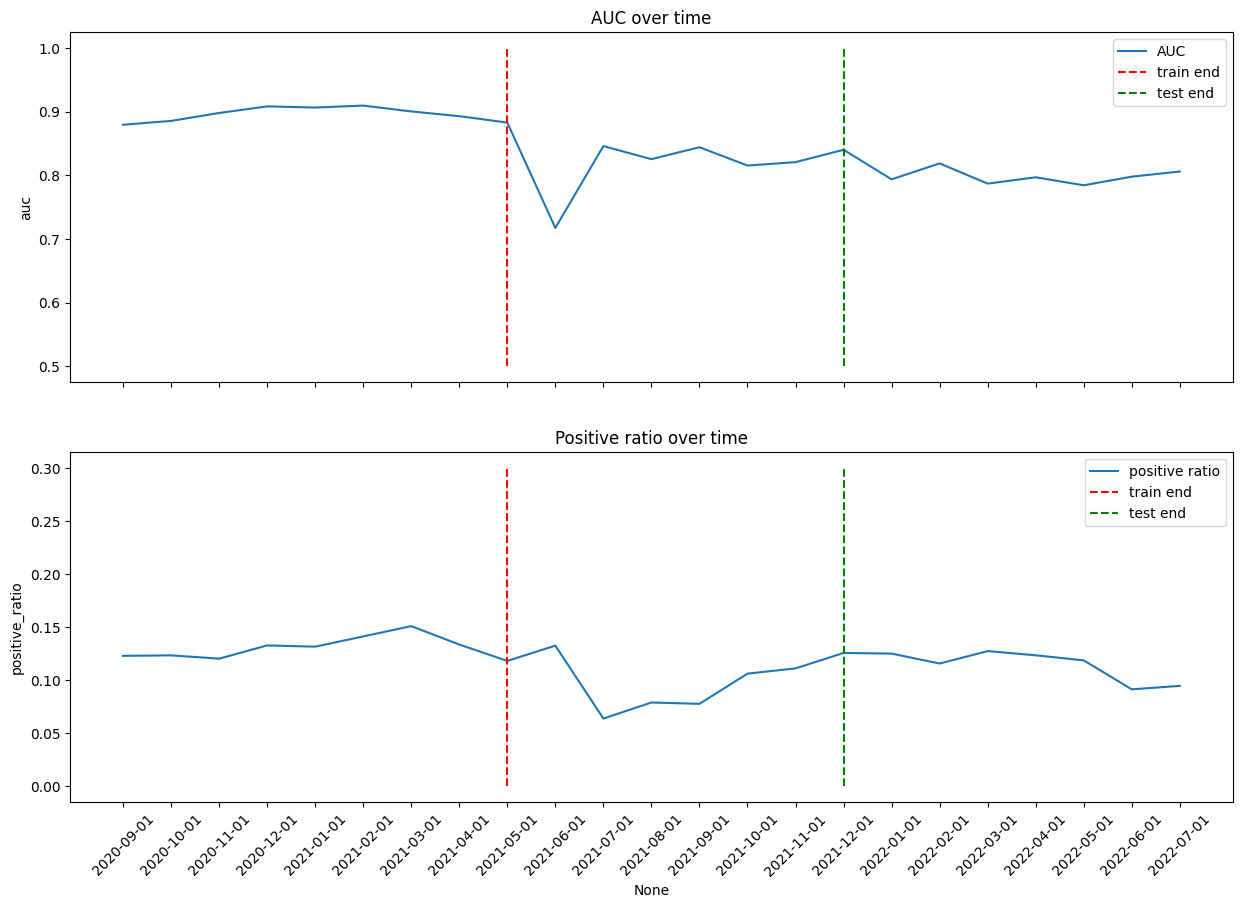

In [20]:
all_data['preds'] = optimal_model.predict_proba(all_data[features])[:, 1]
scored_df = time_based_evaluation(all_data, 'date_reference', target_col=target)

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.lineplot(x=scored_df.index, y=scored_df['auc'], label='AUC', ax=ax[0])
ax[0].set_title('AUC over time')
ax[0].vlines(x=train['date_reference'].max(), ymin=0.5, ymax=1, color='r', linestyle='--', label='train end')
ax[0].vlines(x=test['date_reference'].max(), ymin=0.5, ymax=1, color='g', linestyle='--', label='test end')
ax[0].legend()

sns.lineplot(x=scored_df.index, y=scored_df['positive_ratio'], label='positive ratio', ax=ax[1])
ax[1].set_title('Positive ratio over time')
ax[1].vlines(x=train['date_reference'].max(), ymin=0, ymax=.3, color='r', linestyle='--', label='train end')
ax[1].vlines(x=test['date_reference'].max(), ymin=0, ymax=.3, color='g', linestyle='--', label='test end')
ax[1].legend()
ax[1].tick_params(axis='x', rotation=45)

plt.show()

## Some Reasons for Default:

### Bank side - Economic policies may influence
- High Interest Rates < Chosen feature to try on this model
- Loan Adequacy (Too high for the customer)
- Incorrect assessment of CNPJ risk

### Company Side - Depends on the company and macroeconomic factors

- Insuficient Cash Flow
- Customer Payment Delays - e.g.: Textiles, Wholesalers...
- Changes in customer behavior
- Loss of market share to competitors
- Bad management/Lack of controls

In [21]:
# SELIC starting 1 year before min date
selic_start_date = (pd.to_datetime(all_data['date_reference'].min()) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
selic_end_date = all_data['date_reference'].max()

In [22]:
# including brazilian treasury yield (SELIC) as a feature

url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json'
selic_base = pd.read_json(url)

In [23]:
selic_base

,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9440,01/02/2024,0.041957
9441,02/02/2024,0.041957
9442,05/02/2024,0.041957
9443,06/02/2024,0.041957


In [24]:
selic = selic_base.copy()
selic['data'] = pd.to_datetime(selic['data'], format='%d/%m/%Y')
selic = selic.query(f'data >= "{selic_start_date}" and data <= "{selic_end_date}"')
selic.sort_values('data', inplace=True)
selic.reset_index(drop=True, inplace=True)

# compounded selic rate in 3, 6 and 12 months
selic['valor'] = selic['valor'].astype(float)
selic['valor'] = (1 + selic['valor']/100)
selic['year_month'] = selic['data'].dt.to_period('M')
selic = selic.groupby('year_month').agg({'valor': 'prod'}).reset_index()
selic['selic_compounded_prev_12mo'] = selic['valor'].rolling(12).apply(np.prod, raw=True).shift(1) - 1
selic['selic_compounded_prev_6mo'] = selic['valor'].rolling(6).apply(np.prod, raw=True).shift(1) - 1
selic['selic_compounded_prev_3mo'] = selic['valor'].rolling(3).apply(np.prod, raw=True).shift(1) - 1
selic.dropna(inplace=True)
selic['year_month'] = selic['year_month'].dt.strftime('%Y-%m-01')
selic

,year_month,valor,selic_compounded_prev_12mo,selic_compounded_prev_6mo,selic_compounded_prev_3mo
12,2020-09-01,1.001570,0.038602,0.014341,0.005676
13,2020-10-01,1.001570,0.035431,0.012507,0.005121
14,2020-11-01,1.001495,0.032109,0.011215,0.004746
15,2020-12-01,1.001644,0.029735,0.010344,0.004641
16,2021-01-01,1.001495,0.027578,0.009861,0.004716
17,2021-02-01,1.001345,0.025253,0.009409,0.004641
18,2021-03-01,1.002011,0.023625,0.009153,0.004491
19,2021-04-01,1.002078,0.022225,0.009598,0.004859
20,2021-05-01,1.002703,0.021438,0.010110,0.005444
21,2021-06-01,1.003078,0.021790,0.011329,0.006807


In [25]:
# selic.to_csv('selic.csv', index=False)

In [26]:
train = train.merge(selic, left_on='date_reference', right_on='year_month', how='left')
test = test.merge(selic, left_on='date_reference', right_on='year_month', how='left')
valid = valid.merge(selic, left_on='date_reference', right_on='year_month', how='left')
all_data = all_data.merge(selic, left_on='date_reference', right_on='year_month', how='left')

features_with_external = [
    'chk_esp_cred_rot_a_vencer_pct_risco',
    'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo',
    'cnt_declined_reasons',
    'days_since_oldest_board_member',
    'general_a_vencer_pct_risco',
    'general_a_vencer_weighted_periodo_div_pct_risco',
    'general_limite_de_cred_sum_pct_risco',
    'general_limite_trend_6mo',
    'general_lost_pct_cart_cred',
    'general_lost_pct_risco',
    'general_vencido_max_prev_6mo',
    'general_vencido_pct_carteira_cred__max_prev_6mo',
    'general_vencido_pct_risco_max_prev_6mo',
    'general_vencido_sum_sum_pct_risco',
    'v204r_is_popular_domain',
    'v254r_cnt_board_memebers',
    'years_since_first_relationship',
    'general_limite_de_cred_sum', # necessary to engineered features
    'general_lost_sum', # necessary to engineered features
    'general_vencido_sum', # necessary to engineered features
    'risco_total',
    'selic_compounded_prev_12mo',
    'selic_compounded_prev_6mo',
    'selic_compounded_prev_3mo',
    'random'
    ]

# model with external

model_with_external = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum'])),
    ('classifier', CalibratedClassifierCV(LGBMClassifier(**best_params, random_state=1), method='isotonic', cv=5)),
])

fitted_model_with_external = model_with_external.fit(train[features_with_external], train[target])
preds = fitted_model_with_external.predict_proba(test[features_with_external])[:, 1]
train_preds = fitted_model_with_external.predict_proba(train[features_with_external])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 2738, number of negative: 18220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4894
[LightGBM] [Info] Number of data points in the train set: 20958, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130642 -> initscore=-1.895292
[LightGBM] [Info] Start training from score -1.895292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

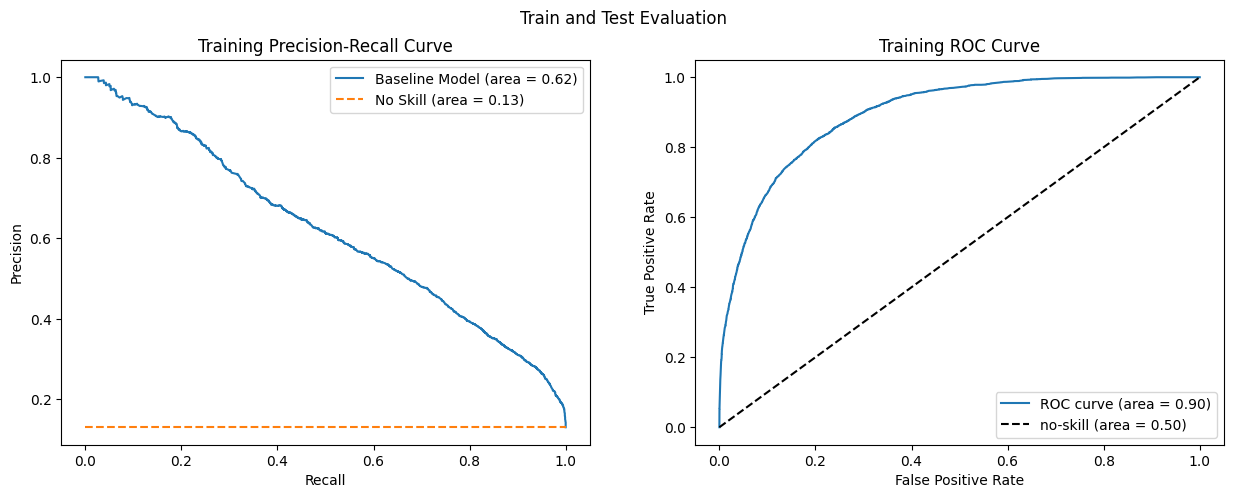

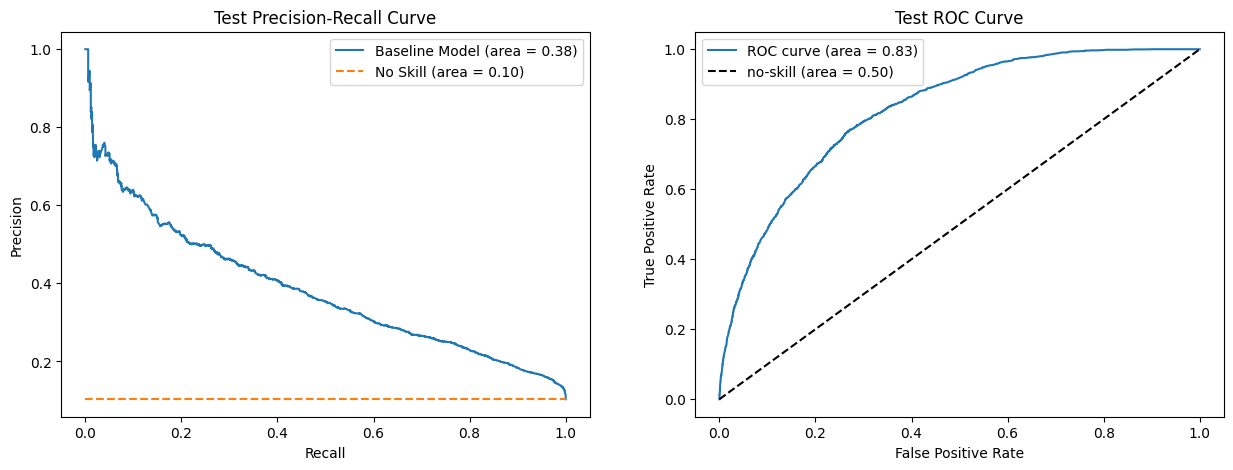

In [27]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

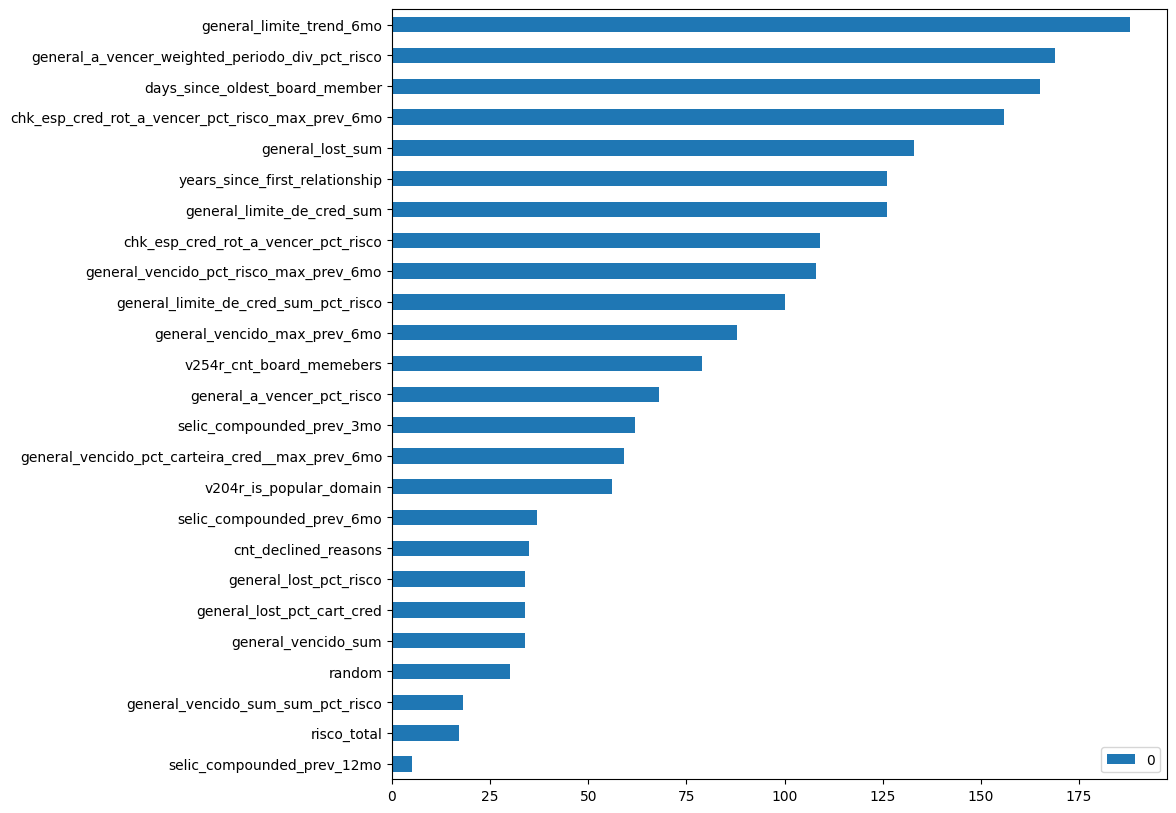

In [28]:
# importances
importances_df = pd.DataFrame(fitted_model_with_external['classifier'].calibrated_classifiers_[0].estimator.feature_importances_, index=features_with_external).sort_values(0)
importances_df.plot(kind='barh', figsize=(10, 10))
plt.show()

In [29]:
random_importances = importances_df.loc['random'].values[0]
features_with_importance_above_random_base = importances_df[importances_df[0] > random_importances].index.tolist()

features_in_log_transform_not_in_importances = [f for f in log_transform_features if f not in features_with_importance_above_random_base]
features_in_log_transform_not_in_importances

features_with_importance_above_random = features_with_importance_above_random_base + features_in_log_transform_not_in_importances

In [30]:
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# def objective(trial):
#     param = {
#         'max_depth': trial.suggest_int('max_depth', 2, 5),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 300),
#         'min_child_samples': trial.suggest_int('min_child_samples', 50, 100),
#         'subsample': trial.suggest_float('subsample', 0.1, 0.6),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#     }
#     opt_model = Pipeline([
#         ('log_transform', LogTransformer(log_transform_features)),
#         ('create_features', FeatureCreation()),
#         ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum', 'general_limite_de_cred_sum'] + features_in_log_transform_not_in_importances)),
#         ('classifier', CalibratedClassifierCV(LGBMClassifier(**param, random_state=1, class_weight='balanced'), method='isotonic', cv=5)),
#     ])
        
#     opt_model.fit(train[features_with_importance_above_random], train[target])
#     preds = opt_model.predict_proba(test[features_with_importance_above_random])[:, 1]
#     return roc_auc_score(test[target], preds)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# study.best_params


In [31]:
# best_params = study.best_params

best_params = {'max_depth': 4,
 'learning_rate': 0.06554020195444601,
 'n_estimators': 56,
 'min_child_samples': 72,
 'subsample': 0.5501602346430039,
 'colsample_bytree': 0.45160434139651867,
 'reg_alpha': 0.8402141112734206,
 'reg_lambda': 0.5122163006202575}

In [32]:
model_input_features = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum', 'general_limite_de_cred_sum'] + features_in_log_transform_not_in_importances))]).transform(train[features_with_importance_above_random])
model_input_columns = model_input_features.columns.tolist()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
# model with external and selected features

model_with_external_and_selected = Pipeline([
    ('log_transform', LogTransformer(log_transform_features)),
    ('create_features', FeatureCreation()),
    ('remove_features', FeatureRemoval(['general_lost_sum', 'general_vencido_sum', 'general_limite_de_cred_sum'] + features_in_log_transform_not_in_importances)),
    ('classifier', CalibratedClassifierCV(LGBMClassifier(**best_params, random_state=1), method='isotonic', cv=5)),
])

fitted_model_with_external_and_selected = model_with_external_and_selected.fit(train[features_with_importance_above_random], train[target])
preds = fitted_model_with_external_and_selected.predict_proba(test[features_with_importance_above_random])[:, 1]
train_preds = fitted_model_with_external_and_selected.predict_proba(train[features_with_importance_above_random])[:, 1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[LightGBM] [Info] Number of positive: 2738, number of negative: 18220
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3864
[LightGBM] [Info] Number of data points in the train set: 20958, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130642 -> initscore=-1.895292
[LightGBM] [Info] Start training from score -1.895292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

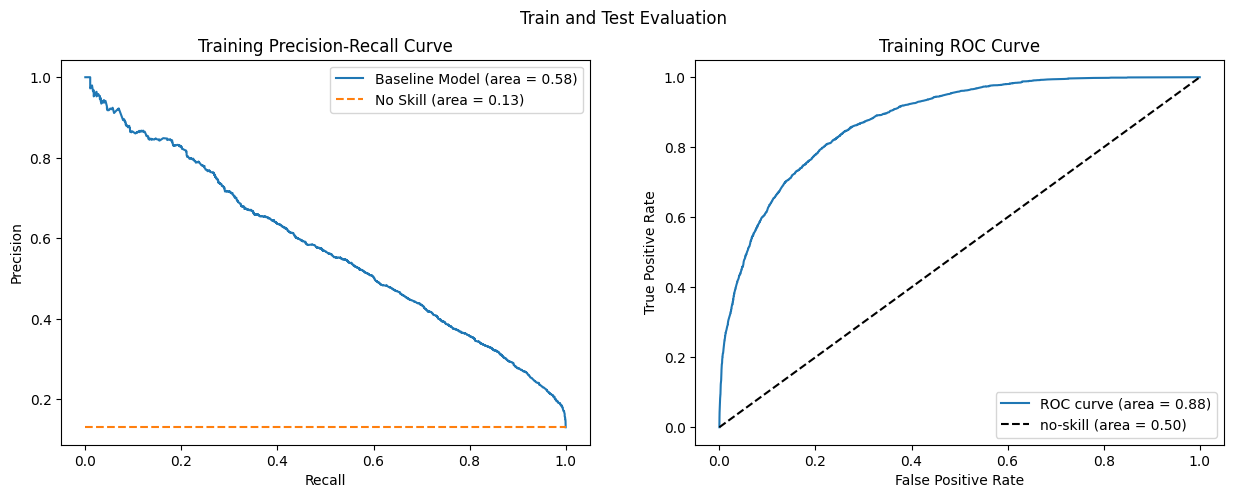

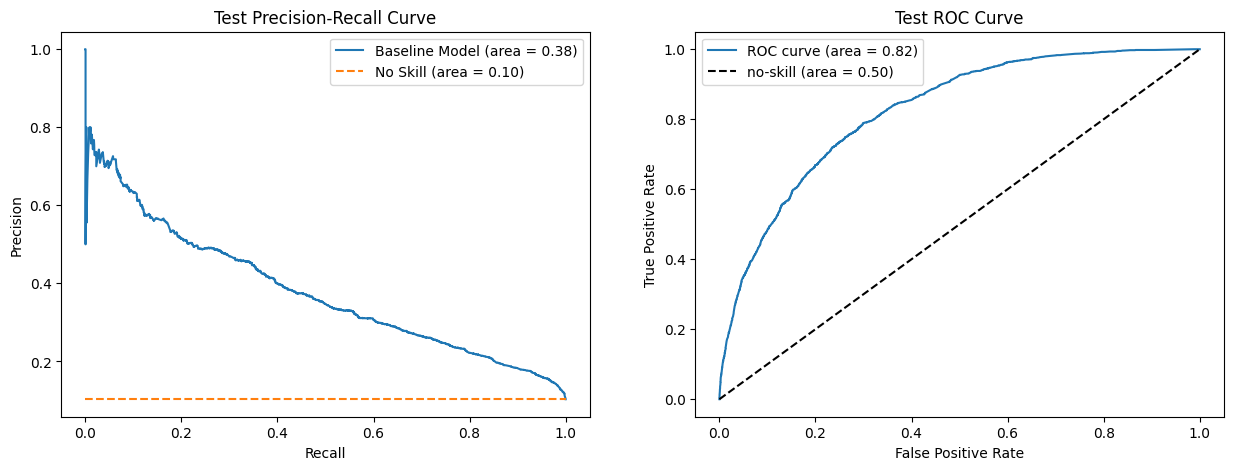

In [34]:
evaluate_model_with_train(train[target], test[target], train_preds, preds)

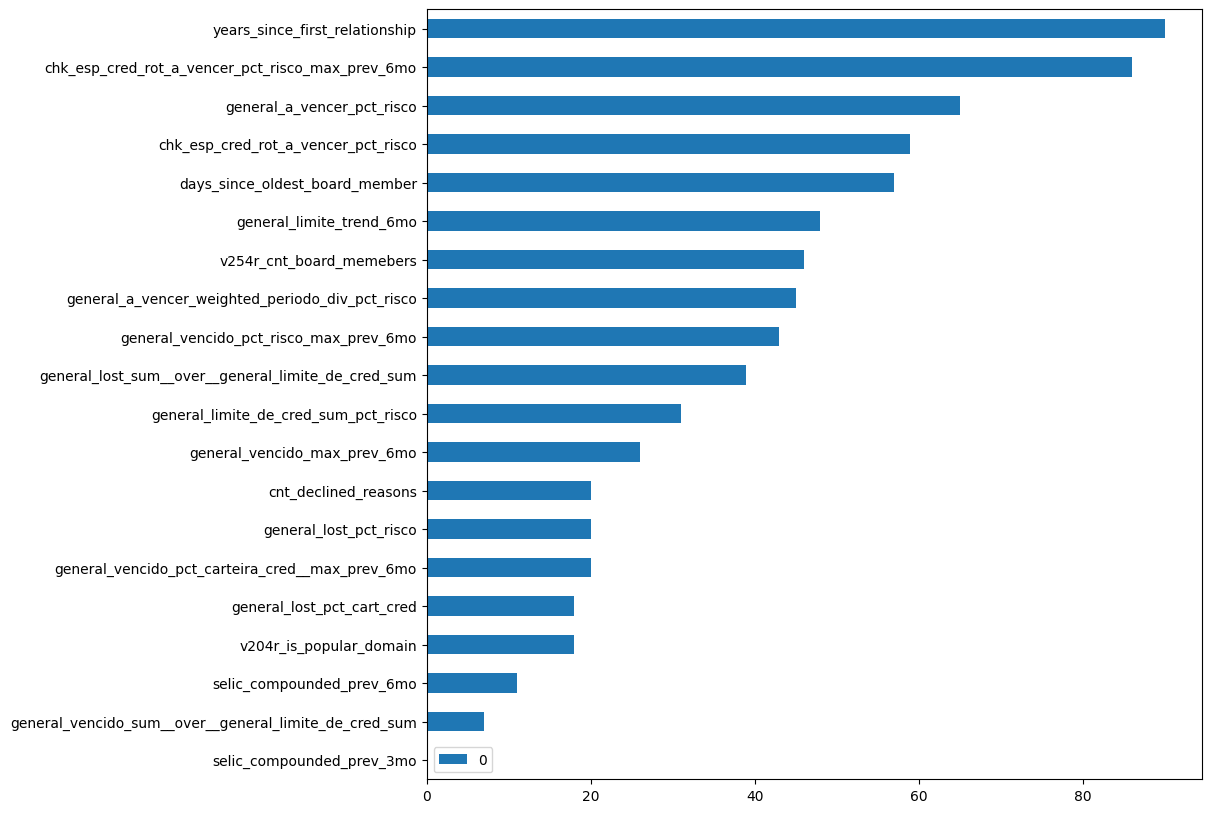

In [35]:
# importances
importances_df = pd.DataFrame(fitted_model_with_external_and_selected['classifier'].calibrated_classifiers_[0].estimator.feature_importances_, index=model_input_columns).sort_values(0)
importances_df.plot(kind='barh', figsize=(10, 10))
plt.show()

In [36]:
# SHAP
explainer = shap.Explainer(fitted_model_with_external_and_selected['classifier'].calibrated_classifiers_[0].estimator)
shap_values = explainer.shap_values(model_input_features[model_input_columns])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


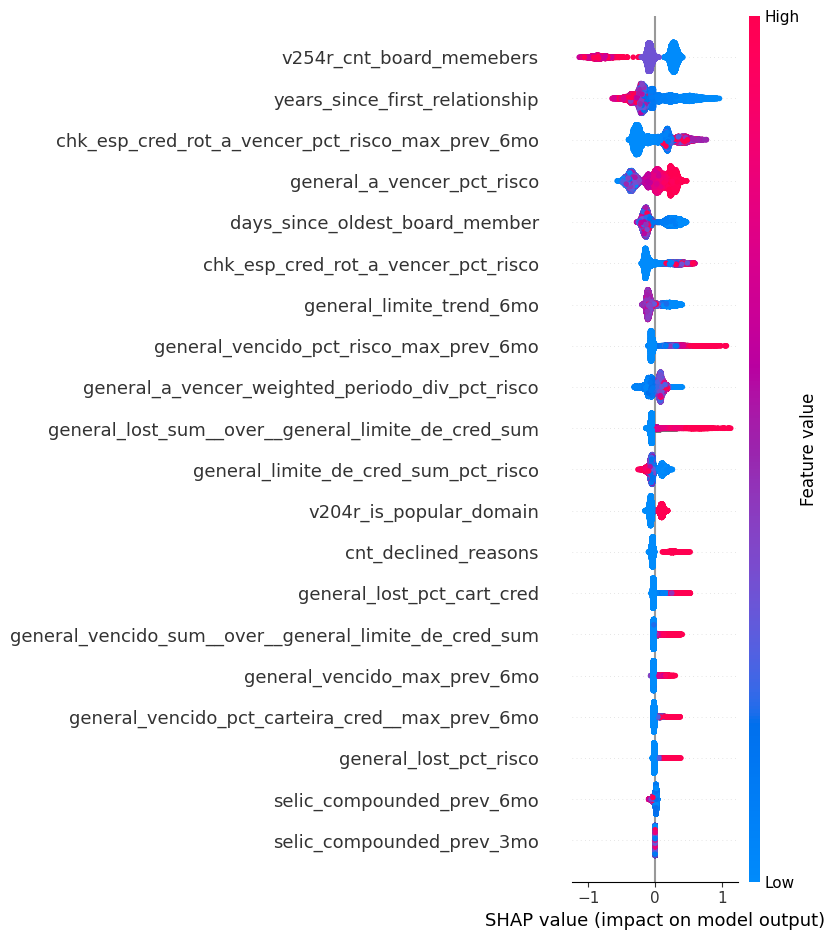

In [37]:
# SHAP summary plot
shap.summary_plot(shap_values[1], model_input_features, feature_names=model_input_columns)

In [38]:
# SHAP force plot for CNPJ 76
train[11:12]

,fake_cnpj,date_reference,general_lost_pct_risco,years_since_first_relationship,chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo,days_since_oldest_board_member,v001r_social_capital,cnt_declined_reasons,chk_esp_cred_rot_a_vencer_pct_risco,general_limite_de_cred_sum_pct_risco,...,general_vencido_max_prev_6mo,general_vencido_pct_risco_max_prev_6mo,general_vencido_pct_carteira_cred__max_prev_6mo,TARGET_default_within_11m,random,year_month,valor,selic_compounded_prev_12mo,selic_compounded_prev_6mo,selic_compounded_prev_3mo
11,508,2020-10-01,0.0,24.852055,0.205895,4.358904,0.0,0,0.004582,0.1905,...,0.0,0.0,0.0,0,0.884869,2020-10-01,1.00157,0.035431,0.012507,0.005121


In [39]:
shap.force_plot(explainer.expected_value[1], shap_values[1][11], model_input_features[model_input_columns].iloc[11], feature_names=model_input_columns)

# Saving the model

In [40]:
# saving the model into a pickle file
import pickle
with open('artifacts/model.pkl', 'wb') as f:
    pickle.dump(fitted_model_with_external_and_selected, f)

In [44]:
with open('artifacts/model_input_features.pkl', 'wb') as f:
    pickle.dump(model_input_columns, f)

with open('artifacts/features.pkl', 'wb') as f:
    pickle.dump(features_with_importance_above_random, f)

with open('artifacts/features_with_importance_above_random_base.pkl', 'wb') as f:
    pickle.dump(features_with_importance_above_random_base, f)

In [42]:
print(model_input_columns)

['general_lost_pct_cart_cred', 'general_lost_pct_risco', 'cnt_declined_reasons', 'selic_compounded_prev_6mo', 'v204r_is_popular_domain', 'general_vencido_pct_carteira_cred__max_prev_6mo', 'selic_compounded_prev_3mo', 'general_a_vencer_pct_risco', 'v254r_cnt_board_memebers', 'general_vencido_max_prev_6mo', 'general_limite_de_cred_sum_pct_risco', 'general_vencido_pct_risco_max_prev_6mo', 'chk_esp_cred_rot_a_vencer_pct_risco', 'years_since_first_relationship', 'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo', 'days_since_oldest_board_member', 'general_a_vencer_weighted_periodo_div_pct_risco', 'general_limite_trend_6mo', 'general_lost_sum__over__general_limite_de_cred_sum', 'general_vencido_sum__over__general_limite_de_cred_sum']


In [43]:
print(features_with_importance_above_random)

['general_vencido_sum', 'general_lost_pct_cart_cred', 'general_lost_pct_risco', 'cnt_declined_reasons', 'selic_compounded_prev_6mo', 'v204r_is_popular_domain', 'general_vencido_pct_carteira_cred__max_prev_6mo', 'selic_compounded_prev_3mo', 'general_a_vencer_pct_risco', 'v254r_cnt_board_memebers', 'general_vencido_max_prev_6mo', 'general_limite_de_cred_sum_pct_risco', 'general_vencido_pct_risco_max_prev_6mo', 'chk_esp_cred_rot_a_vencer_pct_risco', 'general_limite_de_cred_sum', 'years_since_first_relationship', 'general_lost_sum', 'chk_esp_cred_rot_a_vencer_pct_risco_max_prev_6mo', 'days_since_oldest_board_member', 'general_a_vencer_weighted_periodo_div_pct_risco', 'general_limite_trend_6mo', 'general_vencido_sum_sum_pct_risco']
